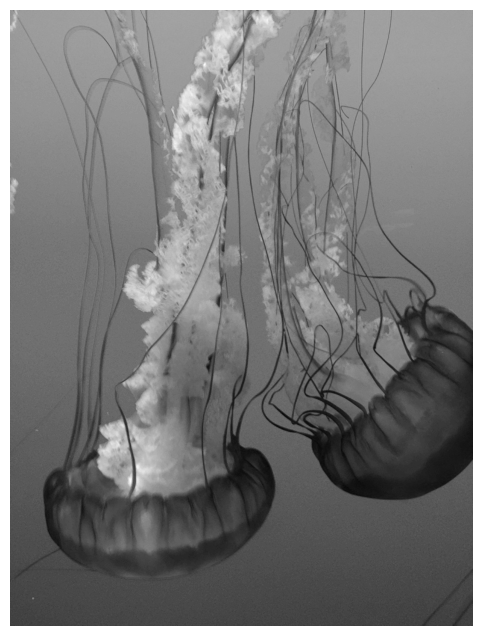

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.image import imread
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams.update({'font.size':18})

A = imread("DATA/jelly.jpg")
A_mean = np.mean(A,-1)# Gray scale conversion

plt.imshow(A_mean, cmap = 'gray')
plt.axis("off")
plt.show()

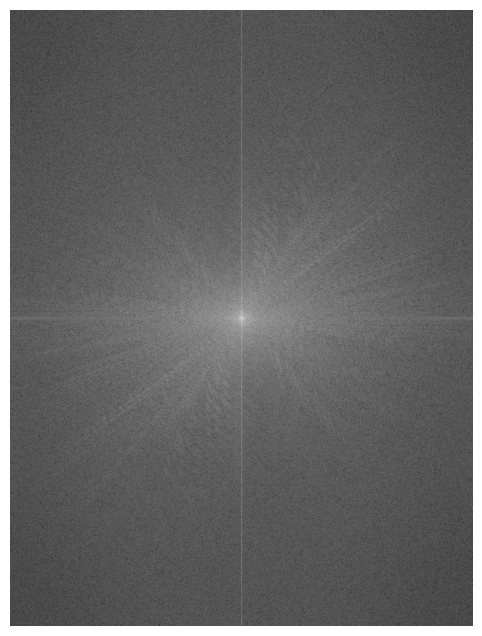

In [11]:
# Computing 2D FFT
At = np.fft.fft2(A_mean)
F = np.log(np.abs(np.fft.fftshift(At))+1)
#F1 = np.log(np.abs(At)+1)
plt.imshow(F,cmap='gray')
plt.axis('off')
plt.show()

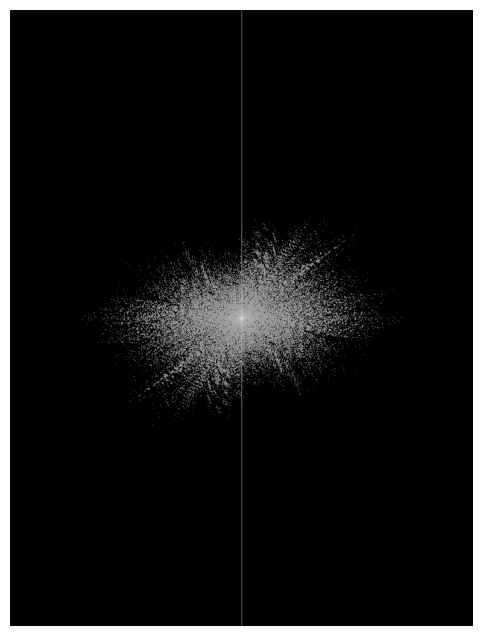

In [15]:
# Thresholding i.e. compression
Bt = np.sort(np.abs(np.reshape(At,-1)))#sorted in ascending
keep = 0.05 # top 5%

thresh = Bt[int(np.floor((1-keep)*len(Bt)))]

ind = np.abs(At)>thresh
Atlow = At*ind
Flow = np.log(np.abs(np.fft.fftshift(Atlow))+1)

plt.imshow(Flow,cmap = 'gray')
plt.axis('off')
plt.show()

C:\Users\simit\AppData\Local\Temp\ipykernel_7324\3365455134.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  Alow = np.fft.ifft2(Atlow).astype('uint8')


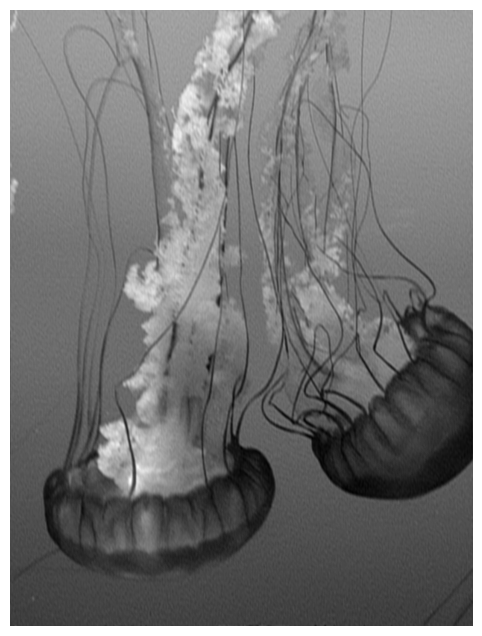

In [18]:
# Reconstruction of the image
Alow = np.fft.ifft2(Atlow).astype('uint8')

plt.imshow(Alow,cmap='gray')
plt.axis('off')
plt.show()

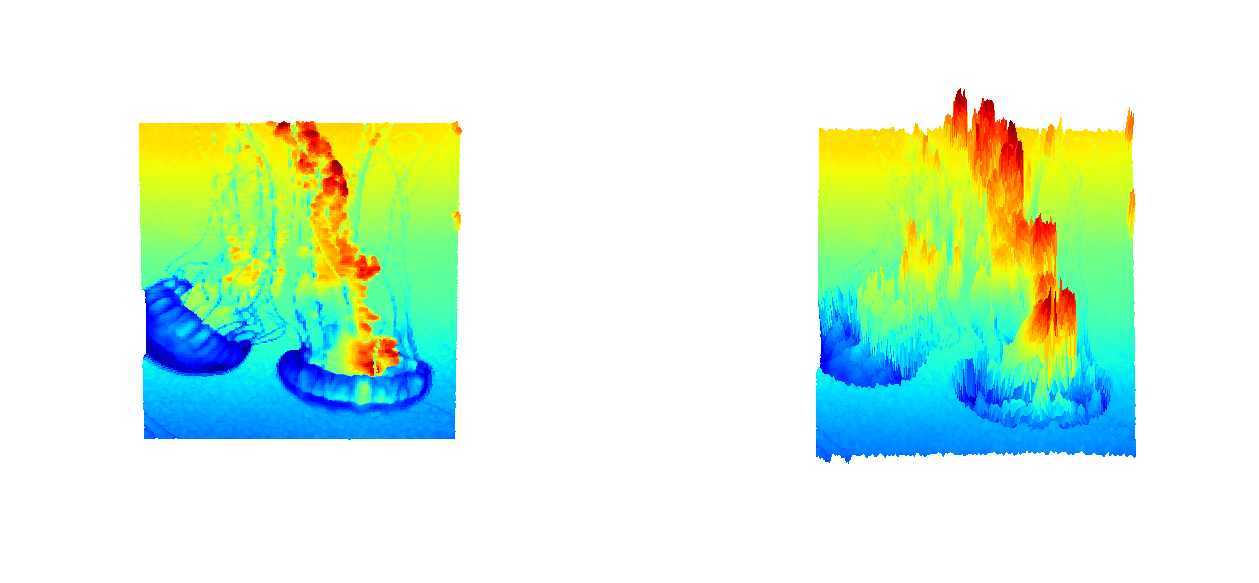

In [22]:
plt.rcParams['figure.figsize'] = [16,8]

fig = plt.figure()
ax1 = fig.add_subplot(1,2,1,projection = '3d')
ax2 = fig.add_subplot(1,2,2,projection = '3d')

Anew = A_mean[::5,::5]

y = np.arange(Anew.shape[0])
x = np.arange(Anew.shape[1])

X,Y = np.meshgrid(x,y)

surf1 = ax1.plot_surface(X,Y, Anew, rstride = 1, cstride = 1, cmap = 'jet', linewidth = 1, antialiased = False)
surf1 = ax2.plot_surface(X,Y, Anew, rstride = 1, cstride = 1, cmap = 'jet', linewidth = 1, antialiased = False)

ax1.view_init(90,90)
ax1.axis('off')

ax2.view_init(60,90)
ax2.axis('off')

plt.show()

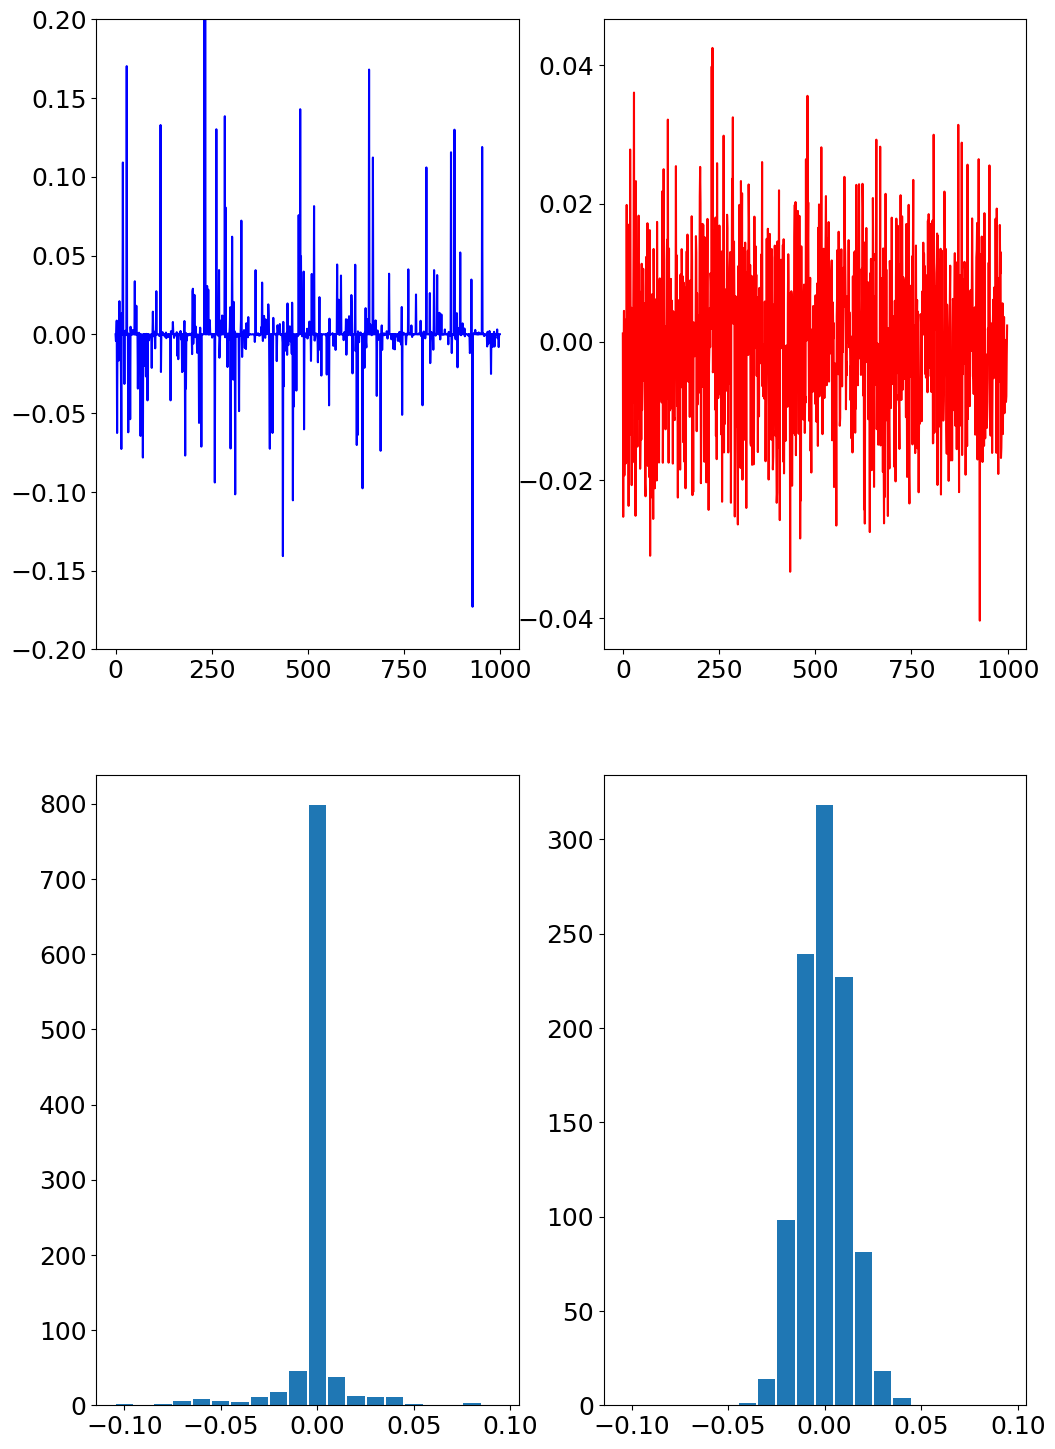

In [23]:
## Underdetermined problem for compressed sensing

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

plt.rcParams['figure.figsize'] = [12,18]
plt.rcParams.update({'font.size':18})


# Problem generation
n = 1000 # s dimension
p = 100 # dim(y)
Theta = np.random.randn(p,n)
y = np.random.randn(p)

# L1 norm minimization

def L1_norm(x):
    return np.linalg.norm(x, ord=1)

constr = ({'type': 'eq', 'fun': lambda x: Theta@x-y})

x0 = np.linalg.pinv(Theta)@y # initializing with L2 solution

res = minimize(L1_norm, x0, method = 'SLSQP', constraints = constr)
s_L1 = res.x

# L2 norm
s_L2 = np.linalg.pinv(Theta)@y

fig, axs = plt.subplots(2,2)
axs = axs.reshape(-1)

axs[0].plot(s_L1, color = 'b', linewidth = 1.5)
axs[0].set_ylim(-0.2,0.2)
axs[1].plot(s_L2, color = 'r', linewidth = 1.5)
axs[0].set_ylim(-0.2,0.2)
axs[2].hist(s_L1, bins = np.arange(-0.105, 0.105, 0.01), rwidth=0.9)
axs[3].hist(s_L2, bins = np.arange(-0.105, 0.105, 0.01), rwidth=0.9)

plt.show()

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10


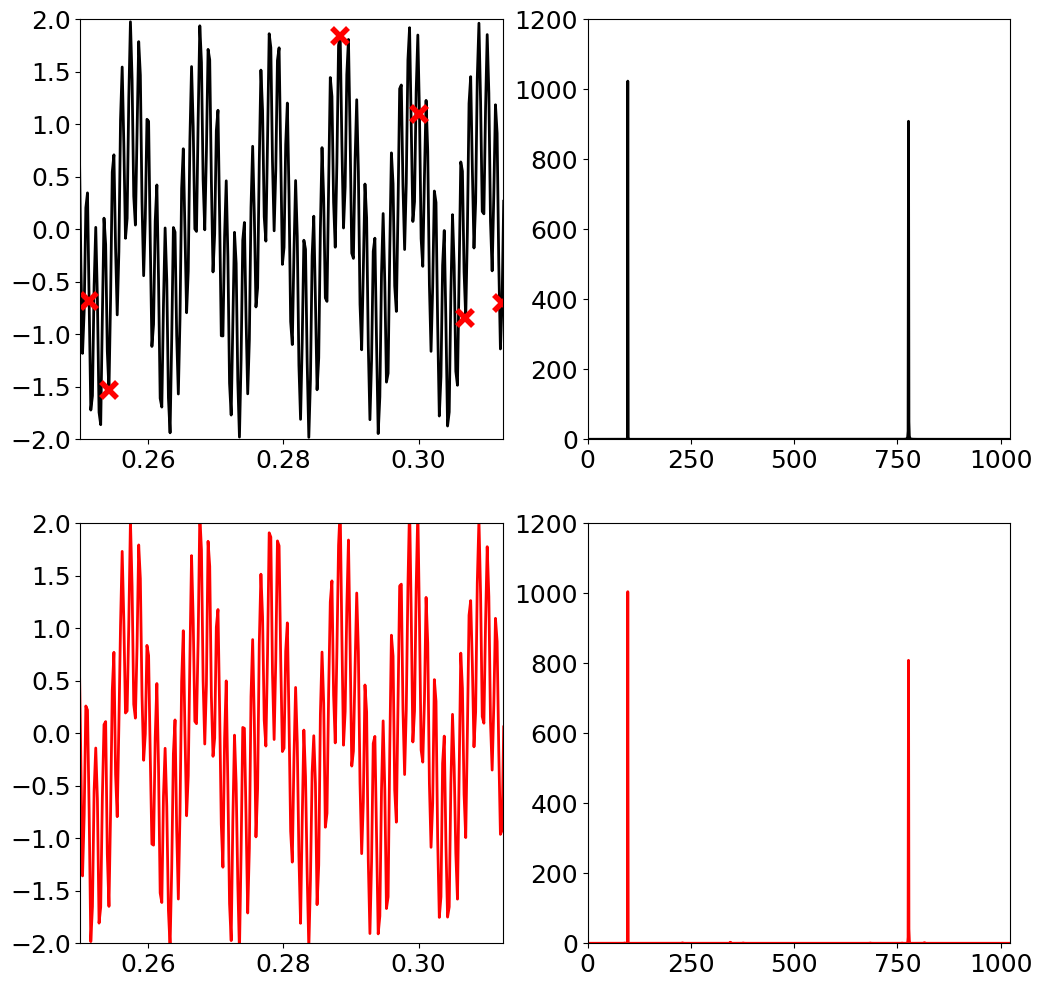

In [15]:
# Audio signal based compressed sensing
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct
from scipy.optimize import minimize
from cosamp import cosamp

plt.rcParams['figure.figsize'] = [12, 12]
plt.rcParams.update({'font.size': 18})

n = 4096
t = np.linspace(0,1,n)
x = np.cos(2*97*np.pi*t) + np.cos(2*777*np.pi*t)
xt = np.fft.fft(x)
PSD = xt*np.conj(xt)/n

# random sampling from signal
p = 128
perm = np.floor(np.random.rand(p)*n).astype(int)
y = x[perm]

# Compresed sensing
psi = dct(np.identity(n))
Theta = psi[perm,:]
s = cosamp.cosamp(Theta, y, 10, tol = 1.e-10, max_iter = 10)
xrecon = idct(s) # reconstructing full signal

## Plot
time_window = np.array([1024,1280])/4096
freq = np.arange(n)
L = int(np.floor(n/2))


fig,axs = plt.subplots(2,2)
axs = axs.reshape(-1)

axs[1].plot(freq[:L],PSD[:L],color='k',linewidth=2)
axs[1].set_xlim(0, 1024)
axs[1].set_ylim(0, 1200)

axs[0].plot(t,x,color='k',linewidth=2)
axs[0].plot(perm/n,y,color='r',marker='x',linewidth=0,ms=12,mew=4)
axs[0].set_xlim(time_window[0],time_window[1])
axs[0].set_ylim(-2, 2)

axs[2].plot(t,xrecon,color='r',linewidth=2)
axs[2].set_xlim(time_window[0],time_window[1])
axs[2].set_ylim(-2, 2)

xtrecon = np.fft.fft(xrecon,n) # computes the (fast) discrete fourier transform
PSDrecon = xtrecon * np.conj(xtrecon)/n # Power spectrum (how much power in each freq)

axs[3].plot(freq[:L],PSDrecon[:L],color='r',linewidth=2)
axs[3].set_xlim(0, 1024)
axs[3].set_ylim(0, 1200)

plt.show()

## L1-Minimization using SciPy
def L1_norm(x):
    return np.linalg.norm(x,ord=1)

constr = ({'type': 'eq', 'fun': lambda x:  Theta @ x - y})
x0 = np.linalg.pinv(Theta) @ y 
res = minimize(L1_norm, x0, method='SLSQP',constraints=constr)
s = res.x

In [17]:
Theta.shape

(128, 4096)

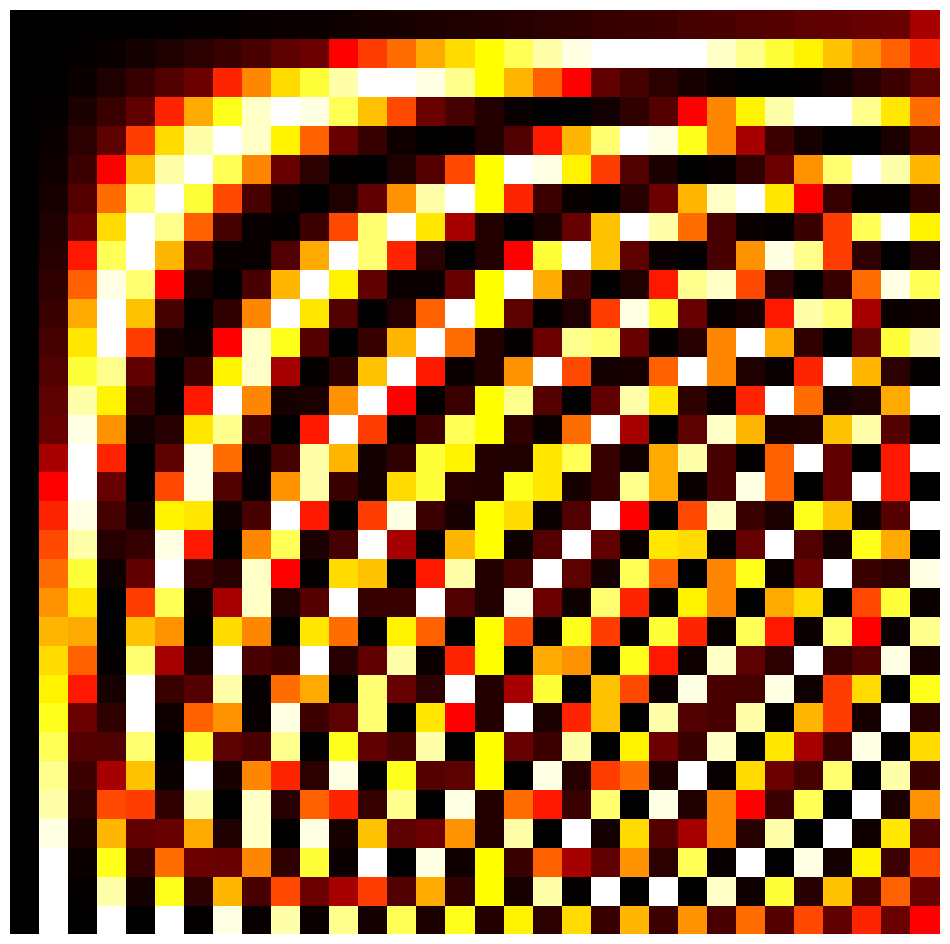

In [1]:
# C matrix for selection
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import scipy.io
from scipy.fftpack import dct, idct
from scipy.optimize import minimize

plt.rcParams['figure.figsize'] = [12, 12]
plt.rcParams.update({'font.size':18})

mat = scipy.io.loadmat("DATA/CC2.mat")

CC = mat['CC']
CC_map = ListedColormap(CC)
p = 14
n = 32

## plot Psi
def padflip(X):
    nx, ny = X.shape
    X = np.flipud(X)
    Y = np.xeros((nx+1, ny+1))
    Y[:-1,:-1] = X
    return Y

Psi = dct(np.identity(n))
plt.pcolor(np.flipud(Psi), cmap=CC_map)
plt.axis('off')
plt.show()

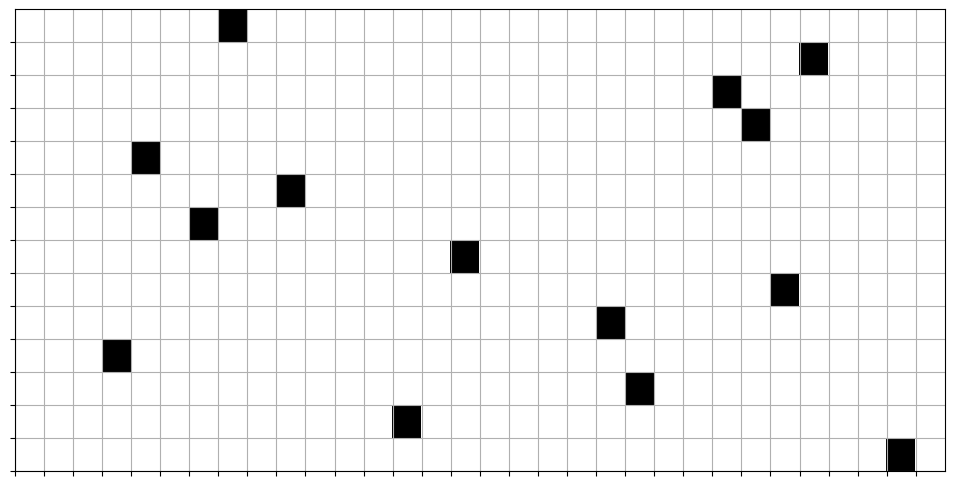

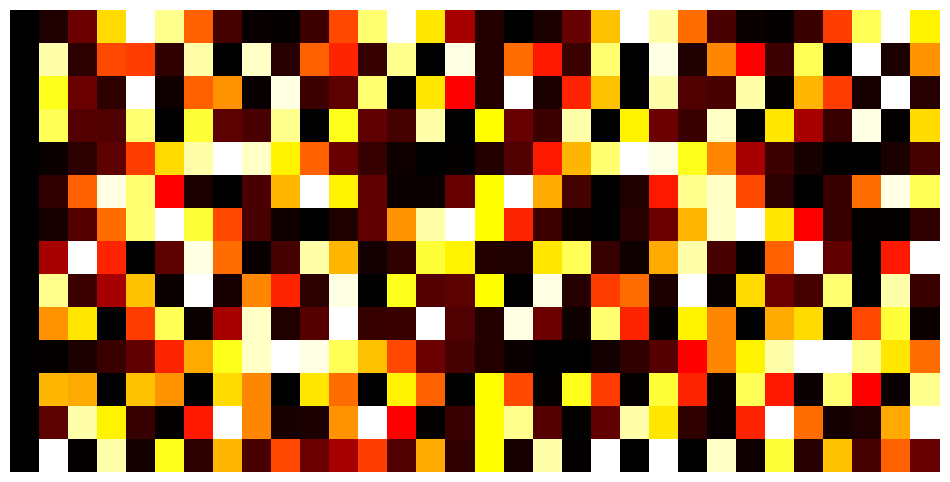

In [2]:
## Plot C
plt.rcParams['figure.figsize'] = [12, 6]
fig,ax = plt.subplots(1,1)
C = np.identity(n)
perm = np.random.permutation(n)[:p]
C = C[perm,:] # compressed measurement
plt.pcolor(np.flipud(C),cmap=CC_map)
plt.grid(True)
plt.xticks(np.arange(n))
plt.yticks(np.arange(len(perm)))
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.show()

## Plot Theta

Theta = C @ Psi
plt.pcolor(np.flipud(Theta),cmap=CC_map)
plt.axis('off')
plt.show()

C:\Users\simit\AppData\Local\Temp\ipykernel_13548\3328121420.py:17: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  sbackslash = np.linalg.lstsq(Theta,y)[0]


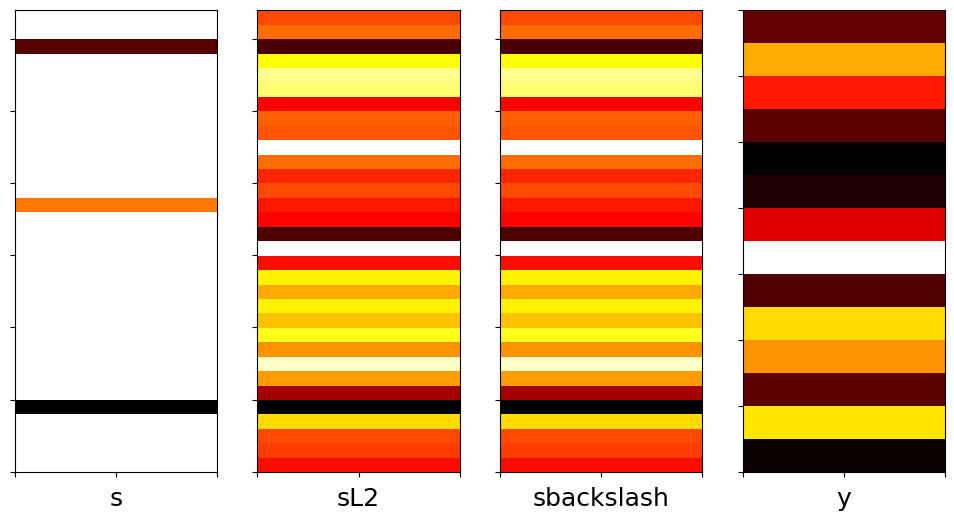

In [4]:
# plotting s and y
s = np.zeros((n,1))
s[2] = 1.4
s[13] = 0.7
s[27] = 2.2

y = C @ Psi @ s

fig, axs = plt.subplots(1,4)
axs[0].pcolor(np.flipud(s),cmap = CC_map)
axs[0].set_xlabel('s')

sL2 = np.linalg.pinv(Theta) @ y
axs[1].pcolor(np.flipud(sL2), cmap = CC_map)
axs[1].set_xlabel('sL2')

sbackslash = np.linalg.lstsq(Theta,y)[0]
axs[2].pcolor(np.flipud(sbackslash), cmap = CC_map)
axs[2].set_xlabel('sbackslash')

axs[3].pcolor(np.flipud(y), cmap = CC_map)
axs[3].set_xlabel('y')

for ax in axs:
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
plt.show()


(32,)


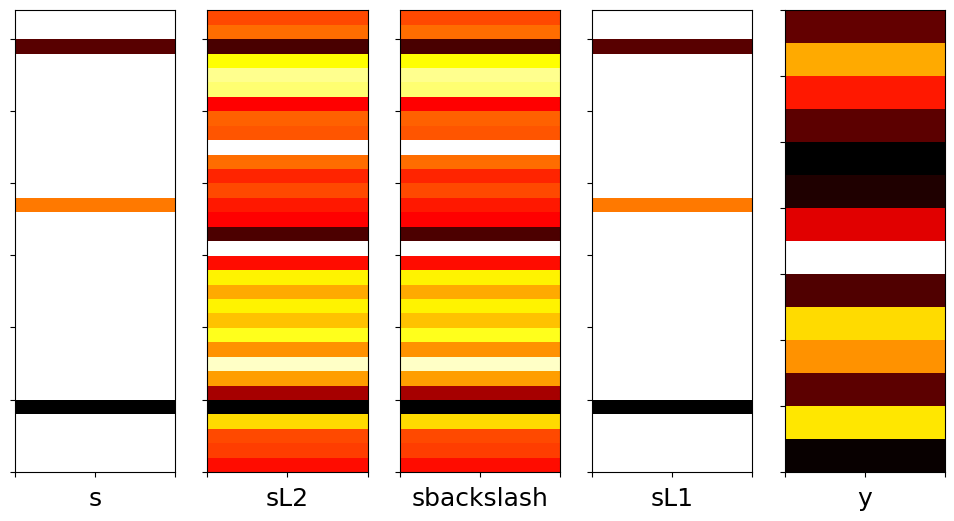

In [21]:
# Using L1 minimization
def L1_norm(x):
    return np.linalg.norm(x, ord = 1)

y = y.reshape(-1)

constr = ({'type':'eq', 'fun':lambda x: Theta @ x - y})

x0 = sL2.reshape(-1)

res = minimize(L1_norm, x0, method = 'SLSQP', constraints = constr)
s2 = res.x

fig, axs = plt.subplots(1,5)
axs[0].pcolor(np.flipud(s),cmap = CC_map)
axs[0].set_xlabel('s')

axs[1].pcolor(np.flipud(sL2), cmap = CC_map)
axs[1].set_xlabel('sL2')

axs[2].pcolor(np.flipud(sbackslash), cmap = CC_map)
axs[2].set_xlabel('sbackslash')

axs[3].pcolor(np.flipud(s2.reshape(-1,1)), cmap = CC_map)
axs[3].set_xlabel('sL1')

axs[4].pcolor(np.flipud(y.reshape(-1,1)), cmap = CC_map)
axs[4].set_xlabel('y')

for ax in axs:
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
plt.show()


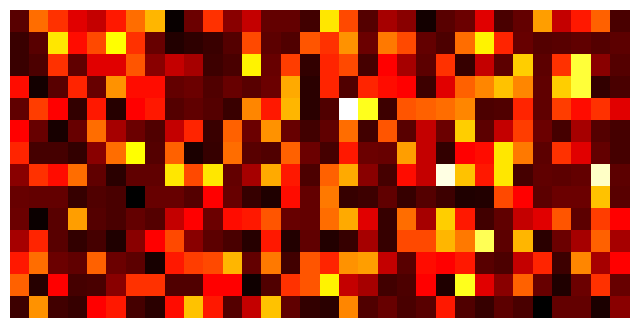

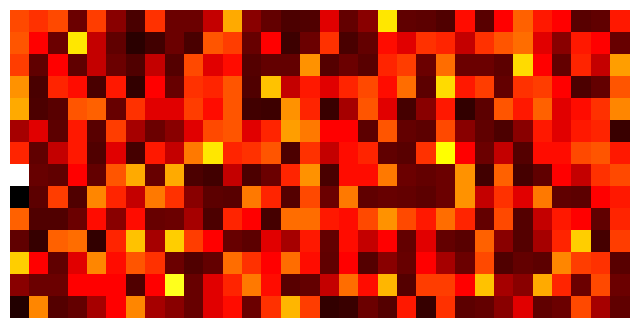

C:\Users\simit\AppData\Local\Temp\ipykernel_13548\1248017335.py:28: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  sbackslash = np.linalg.lstsq(Theta,y)[0]


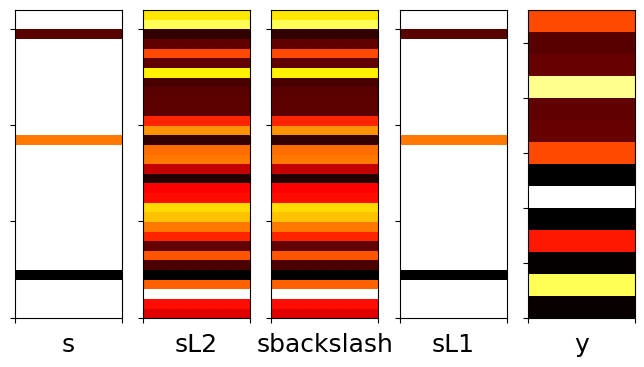

In [34]:
# the same but using Gaussian random
plt.rcParams['figure.figsize'] = [8, 4]

C = np.random.randn(p,n)

plt.figure()
plt.pcolor(np.flipud(C),cmap=CC_map)
plt.axis('off')
plt.show()

Theta = C @ Psi
plt.figure()
plt.pcolor(np.flipud(Theta),cmap=CC_map)
plt.axis('off')
plt.show()


y = C @ Psi @ s

fig, axs = plt.subplots(1,5)
axs[0].pcolor(np.flipud(s),cmap = CC_map)
axs[0].set_xlabel('s')

sL2 = np.linalg.pinv(Theta) @ y
axs[1].pcolor(np.flipud(sL2), cmap = CC_map)
axs[1].set_xlabel('sL2')

sbackslash = np.linalg.lstsq(Theta,y)[0]
axs[2].pcolor(np.flipud(sbackslash), cmap = CC_map)
axs[2].set_xlabel('sbackslash')

y = y.reshape(-1)
constr = ({'type':'eq', 'fun':lambda x: Theta @ x - y})
x0 = sL2.reshape(-1)
res = minimize(L1_norm, x0, method = 'SLSQP', constraints = constr)
s2 = res.x
axs[3].pcolor(np.flipud(s2.reshape(-1,1)), cmap = CC_map)
axs[3].set_xlabel('sL1')

axs[4].pcolor(np.flipud(y.reshape(-1,1)), cmap = CC_map)
axs[4].set_xlabel('y')

for ax in axs:
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
plt.show()


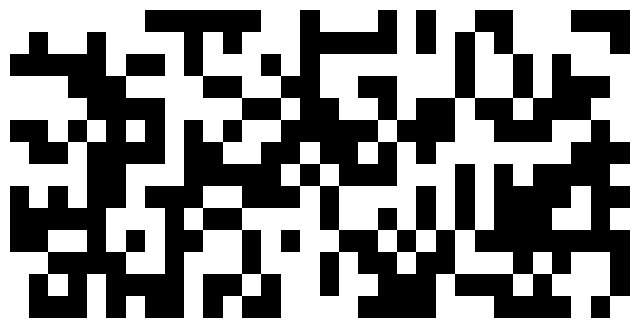

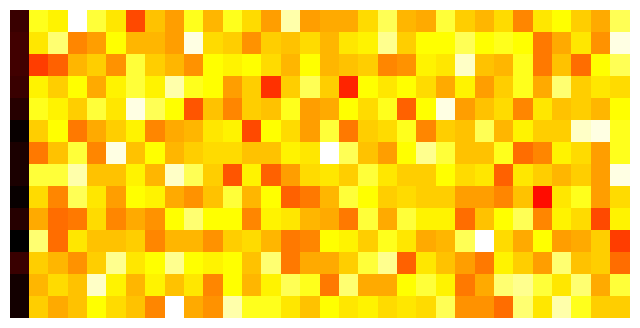

C:\Users\simit\AppData\Local\Temp\ipykernel_13548\3475342489.py:28: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  sbackslash = np.linalg.lstsq(Theta,y)[0]


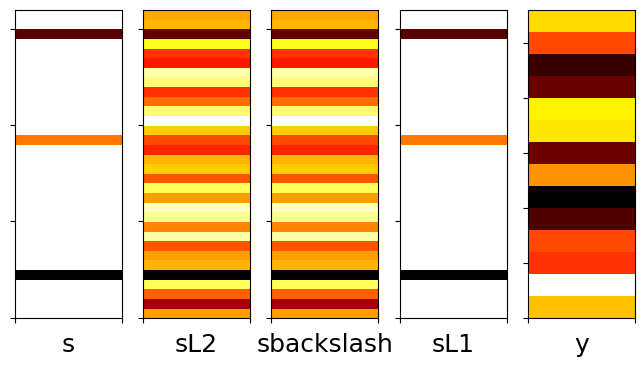

In [35]:
# Bernoulli random

C = np.random.randn(p,n)
C = C>0

plt.figure()
plt.pcolor(np.flipud(C),cmap=CC_map)
plt.axis('off')
plt.show()

plt.figure()
Theta = C @ Psi
plt.pcolor(np.flipud(Theta),cmap=CC_map)
plt.axis('off')
plt.show()


y = C @ Psi @ s

fig, axs = plt.subplots(1,5)
axs[0].pcolor(np.flipud(s),cmap = CC_map)
axs[0].set_xlabel('s')

sL2 = np.linalg.pinv(Theta) @ y
axs[1].pcolor(np.flipud(sL2), cmap = CC_map)
axs[1].set_xlabel('sL2')

sbackslash = np.linalg.lstsq(Theta,y)[0]
axs[2].pcolor(np.flipud(sbackslash), cmap = CC_map)
axs[2].set_xlabel('sbackslash')

y = y.reshape(-1)
constr = ({'type':'eq', 'fun':lambda x: Theta @ x - y})
x0 = sL2.reshape(-1)
res = minimize(L1_norm, x0, method = 'SLSQP', constraints = constr)
s2 = res.x
axs[3].pcolor(np.flipud(s2.reshape(-1,1)), cmap = CC_map)
axs[3].set_xlabel('sL1')

axs[4].pcolor(np.flipud(y.reshape(-1,1)), cmap = CC_map)
axs[4].set_xlabel('y')

for ax in axs:
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
plt.show()

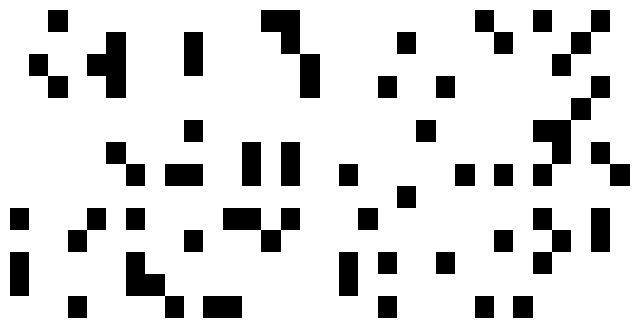

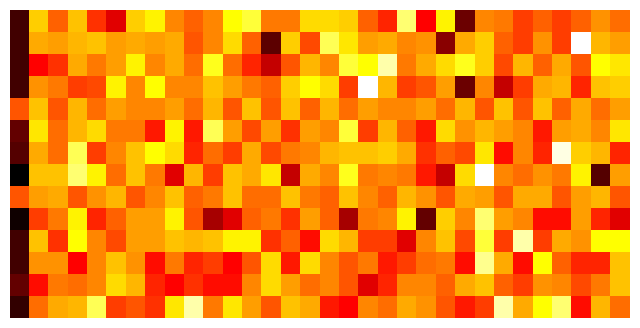

C:\Users\simit\AppData\Local\Temp\ipykernel_13548\2593544699.py:26: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  sbackslash = np.linalg.lstsq(Theta,y)[0]


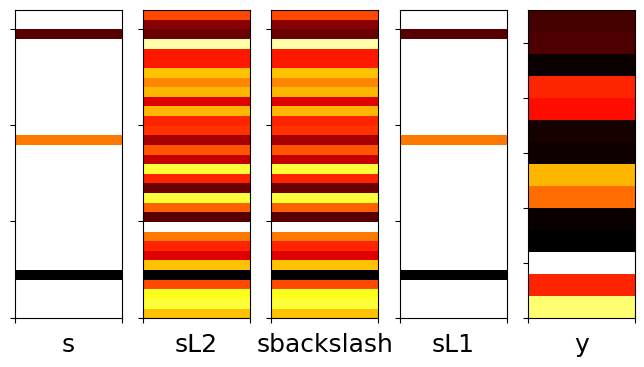

In [36]:
# Sparse Bernoulli
C = np.random.randn(p,n)
C = C > 1

plt.figure()
plt.pcolor(np.flipud(C),cmap=CC_map)
plt.axis('off')
plt.show()

plt.figure()
Theta = C @ Psi
plt.pcolor(np.flipud(Theta),cmap=CC_map)
plt.axis('off')
plt.show()

y = C @ Psi @ s

fig, axs = plt.subplots(1,5)
axs[0].pcolor(np.flipud(s),cmap = CC_map)
axs[0].set_xlabel('s')

sL2 = np.linalg.pinv(Theta) @ y
axs[1].pcolor(np.flipud(sL2), cmap = CC_map)
axs[1].set_xlabel('sL2')

sbackslash = np.linalg.lstsq(Theta,y)[0]
axs[2].pcolor(np.flipud(sbackslash), cmap = CC_map)
axs[2].set_xlabel('sbackslash')

y = y.reshape(-1)
constr = ({'type':'eq', 'fun':lambda x: Theta @ x - y})
x0 = sL2.reshape(-1)
res = minimize(L1_norm, x0, method = 'SLSQP', constraints = constr)
s2 = res.x
axs[3].pcolor(np.flipud(s2.reshape(-1,1)), cmap = CC_map)
axs[3].set_xlabel('sL1')

axs[4].pcolor(np.flipud(y.reshape(-1,1)), cmap = CC_map)
axs[4].set_xlabel('y')

for ax in axs:
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
plt.show()

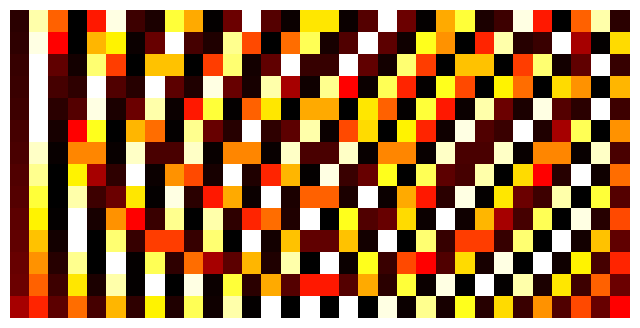

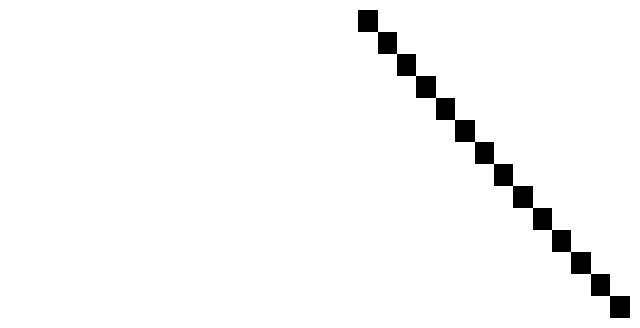

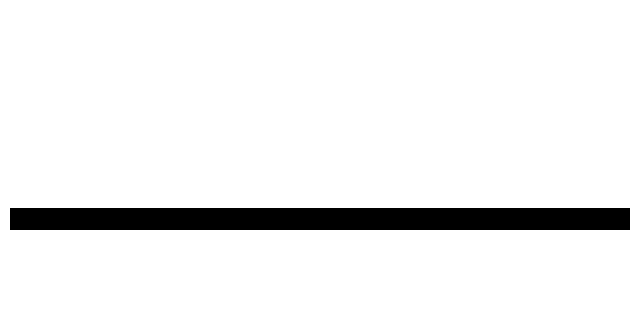

C:\Users\simit\AppData\Local\Temp\ipykernel_13548\2863824556.py:35: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  sbackslash = np.linalg.lstsq(Theta,y)[0]


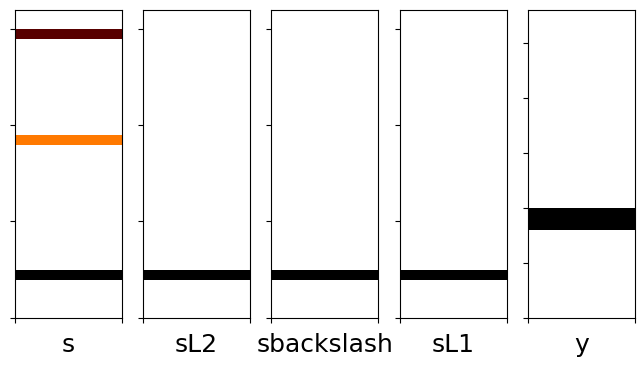

In [37]:
# Bad C and Theta --- using DCT measurement
C = idct(np.identity(n))
perm = np.arange(n-p,n)
C = C[perm,:]

plt.figure()
plt.pcolor(np.flipud(C),cmap = CC_map)
plt.axis('off')
plt.show()


plt.figure()
Theta = C @ Psi
plt.pcolor(np.flipud(Theta),cmap=CC_map)
plt.axis('off')
plt.show()

plt.figure()
y = Theta @ s
plt.pcolor(np.flipud(y),cmap=CC_map)
plt.axis('off')
plt.show()


y = C @ Psi @ s

fig, axs = plt.subplots(1,5)
axs[0].pcolor(np.flipud(s),cmap = CC_map)
axs[0].set_xlabel('s')

sL2 = np.linalg.pinv(Theta) @ y
axs[1].pcolor(np.flipud(sL2), cmap = CC_map)
axs[1].set_xlabel('sL2')

sbackslash = np.linalg.lstsq(Theta,y)[0]
axs[2].pcolor(np.flipud(sbackslash), cmap = CC_map)
axs[2].set_xlabel('sbackslash')

y = y.reshape(-1)
constr = ({'type':'eq', 'fun':lambda x: Theta @ x - y})
x0 = sL2.reshape(-1)
res = minimize(L1_norm, x0, method = 'SLSQP', constraints = constr)
s2 = res.x
axs[3].pcolor(np.flipud(s2.reshape(-1,1)), cmap = CC_map)
axs[3].set_xlabel('sL1')

axs[4].pcolor(np.flipud(y.reshape(-1,1)), cmap = CC_map)
axs[4].set_xlabel('y')

for ax in axs:
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
plt.show()

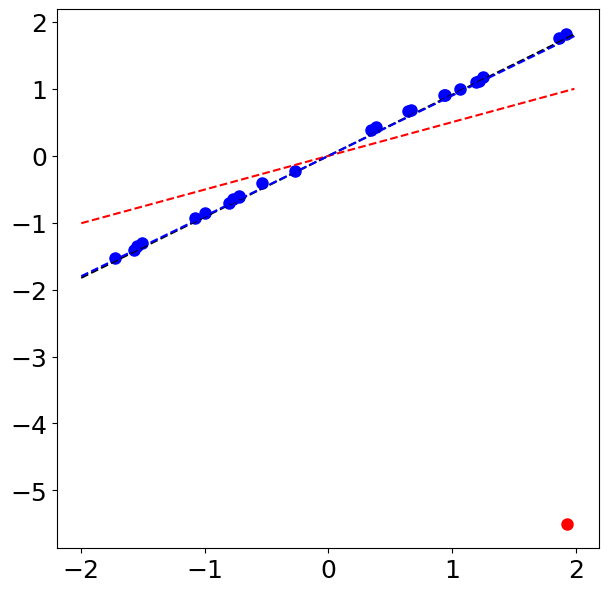

In [42]:
# Roubust Regression
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

plt.rcParams['figure.figsize'] = [7,7]
plt.rcParams.update({'font.size':18})

x = np.sort(4*(np.random.rand(25,1) - 0.5), axis = 0)
b = 0.9*x + 0.1*np.random.rand(len(x),1) # line with noise

atrue = np.linalg.lstsq(x,b,rcond = None)[0] # least square slope, no outliers included
atrue = atrue.item(0)

b[-1] = -5.5 # outlier
acorrupt = np.linalg.lstsq(x,b, rcond = None)[0] # new slope using least squares
acorrupt = acorrupt.item(0)

#Using L1
def L1_norm(a):
    return np.linalg.norm(a*x-b, ord = 1)

a0 = acorrupt # initializing to l2 solution

res = minimize(L1_norm, a0)
aL1 = res.x[0]

plt.figure()
plt.plot(x[:-1], b[:-1], 'ob', ms = 8)
plt.plot(x[-1], b[-1], 'or', ms = 8)

xgrid = np.arange(-2,2,0.01)
plt.plot(xgrid, atrue*xgrid, '--k')
plt.plot(xgrid, acorrupt*xgrid, '--r')
plt.plot(xgrid, aL1*xgrid, '--b')

plt.show()

In [58]:
print(atrue)# no outlier
print(np.linalg.pinv(x)@b) # L2 with outlier 
print(acorrupt)# L2 with outlier
print(aL1)# L1 with outlier

0.9116401264479388
[[0.50362155]]
0.5036215458795108
0.8995130216026186


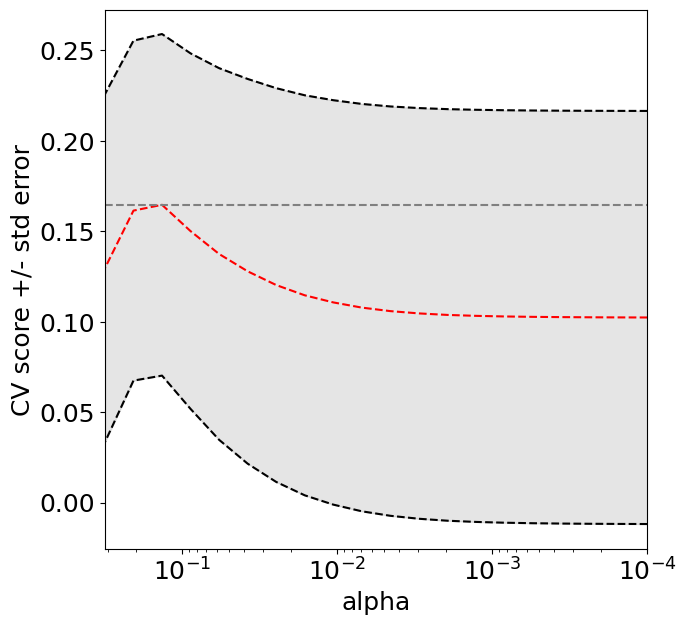

In [1]:
# LASSO - least absolute shrinkage and selection operator
# x = argmin ||Ax' - b||2 + lambda*||s||1

# if there is not enough data to have a sufficiently large training and test set, it is common to repeatedly train and test 
# the model on random selection of the data (often 80% for training and 20% for
#  testing), resulting in a cross-validated performance. 

import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from sklearn import linear_model
from sklearn import model_selection

plt.rcParams['figure.figsize'] = [7, 7]
plt.rcParams.update({'font.size': 18})

A =  np.random.randn(100,10)
x = np.array([0, 0, 1, 0, 0, 0, -1, 0, 0, 0])
b = A@x + 2*np.random.randn(100)

xL2 = np.linalg.pinv(A) @b

reg = linear_model.LassoCV(cv=10).fit(A,b)

lasso = linear_model.Lasso(random_state = 0, max_iter = 10000)
alphas = np.logspace(-4,-0.5,20)

tuned_parameters = [{'alpha':alphas}]

clf = model_selection.GridSearchCV(lasso, tuned_parameters, cv = 10, refit = False)
clf.fit(A,b)

scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']
plt.semilogx(alphas,scores, 'r--')

# error lines
std_error = scores_std/np.sqrt(10)

plt.semilogx(alphas, scores + std_error, 'k--')
plt.semilogx(alphas, scores - std_error, 'k--')
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha = 0.1, color = 'k')

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle = '--', color = '.5')
plt.xlim(alphas[-1], alphas[0])
plt.show()

XL1 = linear_model.Lasso(alpha = clf.best_params_['alpha'])
XL1.fit(A,b)
XL1 = XL1.coef_
XL1DeBiased = np.linalg.pinv(A[:,np.abs(XL1)>0])@b

# print(XL1DeBiased)
# print(XL1)

# Alternate method for lasso model
# print(reg.coef_)

In [89]:
# Sparse representation
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from sklearn import linear_model
from sklearn import model_selection
from scipy.optimize import minimize
from skimage.transform import resize
from matplotlib.image import imread


plt.rcParams['figure.figsize'] = [7, 7]
plt.rcParams.update({'font.size': 18})

mustache = imread("DATA/mustache.jpg")
mustache = np.mean(mustache, -1)

mustache = (mustache/255).astype(int)
mustache = mustache.T

mat = scipy.io.loadmat("DATA/allFaces.mat")
X = mat['faces']
nfaces = mat['nfaces'].reshape(-1)
n = int(mat['n'])
m = int(mat['m'])

# Builing the training and test sets
nTrain = 30
nTest = 20
nPeople = 20
Train = np.zeros((X.shape[0], nTrain*nPeople))
Test = np.zeros((X.shape[0], nTest*nPeople))

for k in range(nPeople):
    baseind = 0
    if k > 0:
        baseind = np.sum(nfaces[:k])

    inds = range(baseind, baseind + nfaces[k])
    Train[:,k*nTrain:(k+1)*nTrain] = X[:,inds[:nTrain]]
    Test[:,k*nTest:(k+1)*nTest] = X[:,inds[nTrain:(nTrain+nTest)]]

# Downsampling to build Theta

M = Train.shape[1]

Theta = np.zeros((120,M))
for k in range(M):
    temp = np.reshape(np.copy(Train[:,k]),(m,n))
    tempSmall = resize(temp, (10,12), anti_aliasing = True)
    Theta[:,k] = np.reshape(tempSmall, -1)
    

# renormalize the columns of Theta
normTheta = np.zeros(M)
for k in range(M):
    normTheta[k] = np.linalg.norm(Theta[:,k])
    Theta[:,k] = Theta[:,k]/normTheta[k]
    

# Occlude test image
# selected image 6 from person 9 ind = 125
x1 = np.copy(Test[:,125])# clean image
x2 = np.copy(Test[:,125])*mustache.reshape(n*m)
randvec = np.random.permutation(n*m)
first30 = randvec[:int(np.floor(0.3*len(randvec)))]
vals30 = (255*np.random.rand(*first30.shape)).astype(int)
x3 = np.copy(x1)
x3[first30] = vals30# 30% occluded
x4 = np.copy(x1) + 50*np.random.randn(*x1.shape)# noise 


X = np.zeros((x1.shape[0],4))
X[:,0] = x1
X[:,1] = x2
X[:,2] = x3
X[:,3] = x4

Y = np.zeros((120,4))
for k in range(4):
    temp = np.reshape(np.copy(X[:,k]),(m,n))
    tempSmall = resize(temp, (10,12), anti_aliasing=True)
    Y[:,k] = np.reshape(tempSmall, -1)



C:\Users\simit\AppData\Local\Temp\ipykernel_9016\2515888489.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  n = int(mat['n'])
C:\Users\simit\AppData\Local\Temp\ipykernel_9016\2515888489.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  m = int(mat['m'])


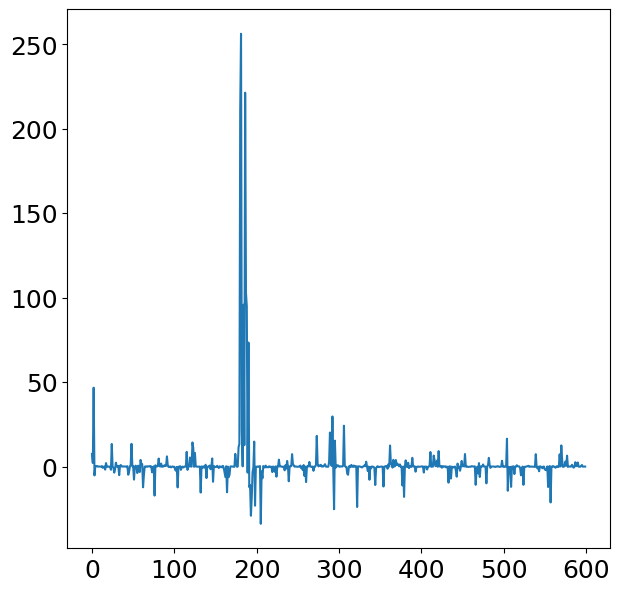

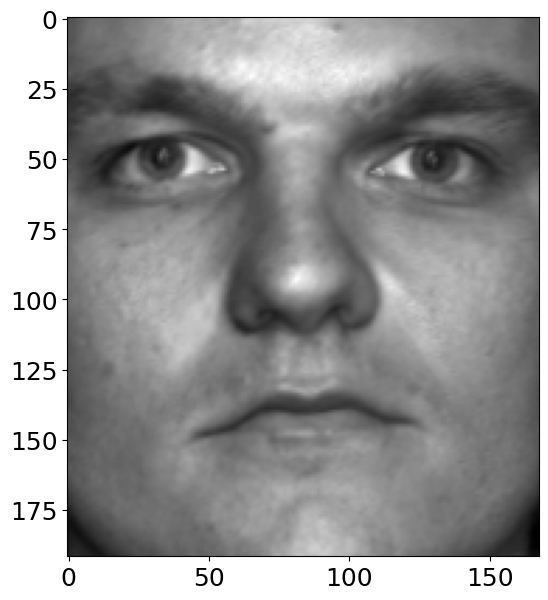

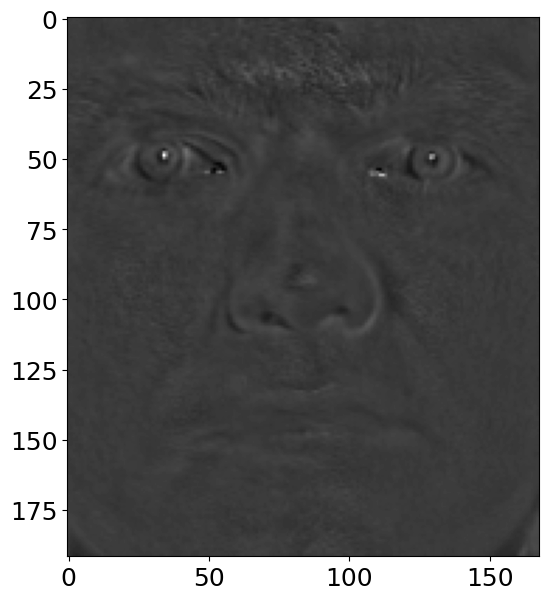

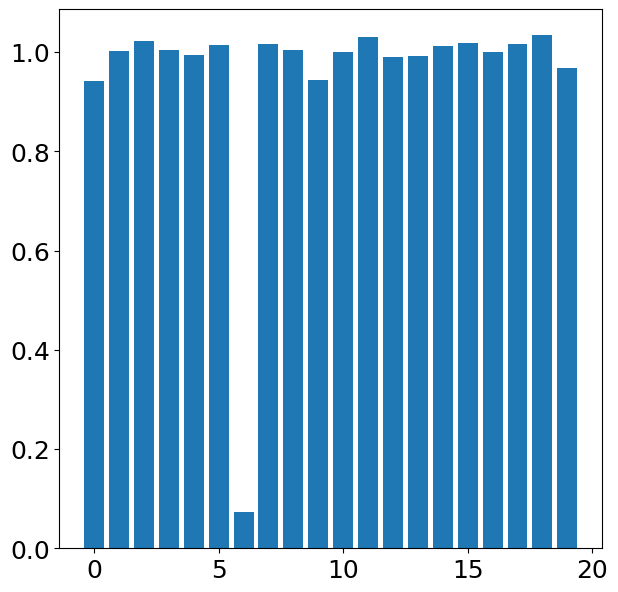

In [90]:
# L1 search, Testclean
y1 = np.copy(Y[:,0])
eps = 0.01

# L1 norm
def L1_norm(x):
    return np.linalg.norm(x,ord = 1)

constr = ({'type':'ineq', 'fun':lambda x: eps - np.linalg.norm(Theta@x - y1,2)})
x0 = np.linalg.pinv(Theta)@y1
res = minimize(L1_norm, x0, method = 'SLSQP', constraints = constr)
s1 = res.x

plt.figure()
plt.plot(s1)

plt.figure()
plt.imshow(np.reshape(Train @ (s1/normTheta), (m,n)).T, cmap='gray')

plt.figure()
plt.imshow(np.reshape(x1 - Train @ (s1/normTheta), (m,n)).T, cmap='gray')

binErr = np.zeros(nPeople)
for k in range(nPeople):
    L = range(k*nTrain, (k+1)*nTrain)
    binErr[k] = np.linalg.norm(x1 - Train[:,L] @ (s1[L]/normTheta[L]))/np.linalg.norm(x1)
    
plt.figure()
plt.bar(range(nPeople),binErr)
plt.show()

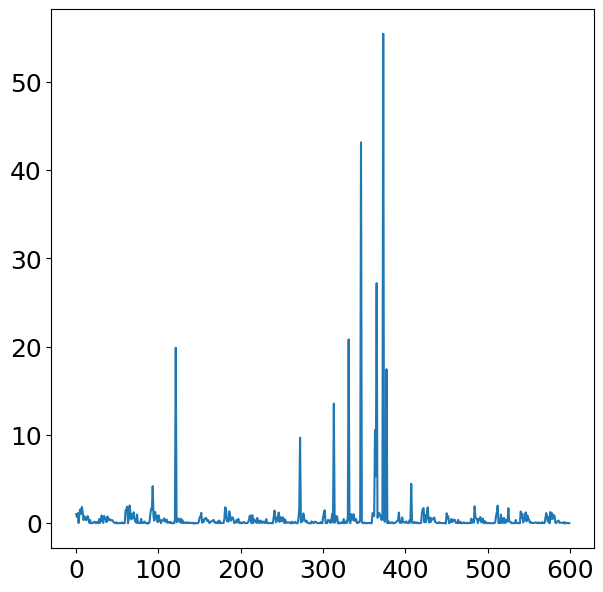

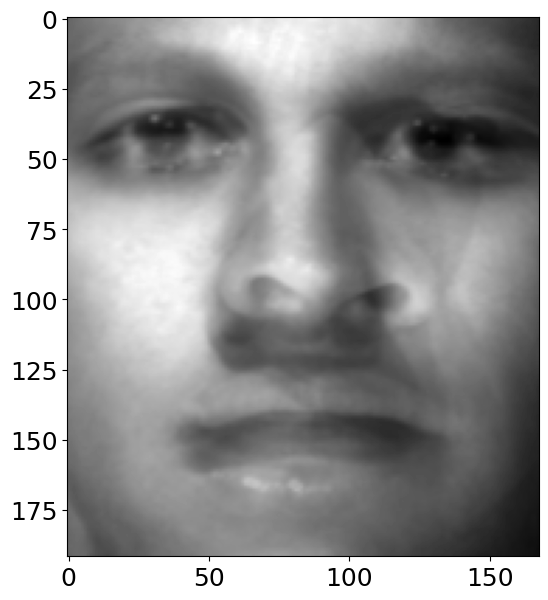

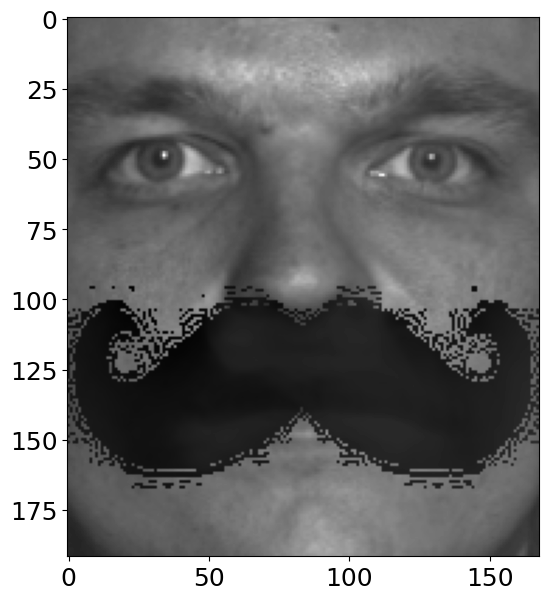

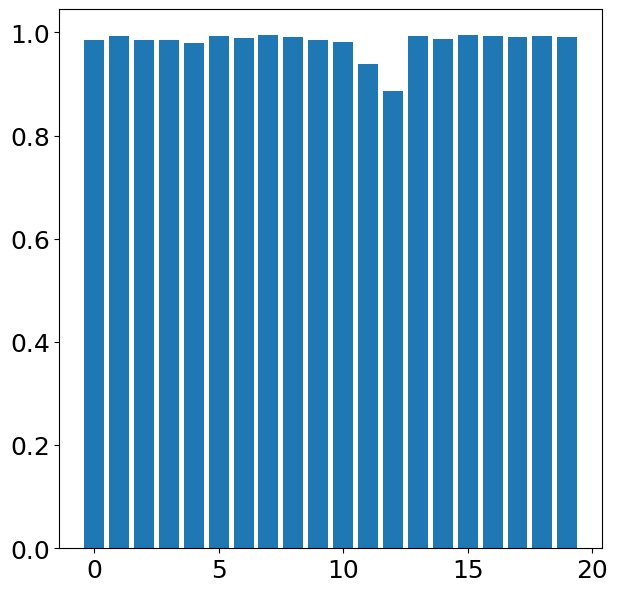

In [91]:
y2 = np.copy(Y[:,1])
eps = 500

# L1 norm
def L1_norm(x):
    return np.linalg.norm(x,ord = 1)

constr = ({'type':'ineq', 'fun':lambda x: eps - np.linalg.norm(Theta@x - y2,2)})
x0 = np.linalg.pinv(Theta)@y2
res = minimize(L1_norm, x0, method = 'SLSQP', constraints = constr)
s2 = res.x


plt.figure()
plt.plot(s2)

plt.figure()
plt.imshow(np.reshape(Train @ (s2/normTheta), (m,n)).T, cmap='gray')

plt.figure()
plt.imshow(np.reshape(x2 - Train @ (s2/normTheta), (m,n)).T, cmap='gray')

binErr = np.zeros(nPeople)
for k in range(nPeople):
    L = range(k*nTrain, (k+1)*nTrain)
    binErr[k] = np.linalg.norm(x2 - Train[:,L] @ (s2[L]/normTheta[L]))/np.linalg.norm(x2)

plt.figure()
plt.bar(range(nPeople),binErr)
plt.show()


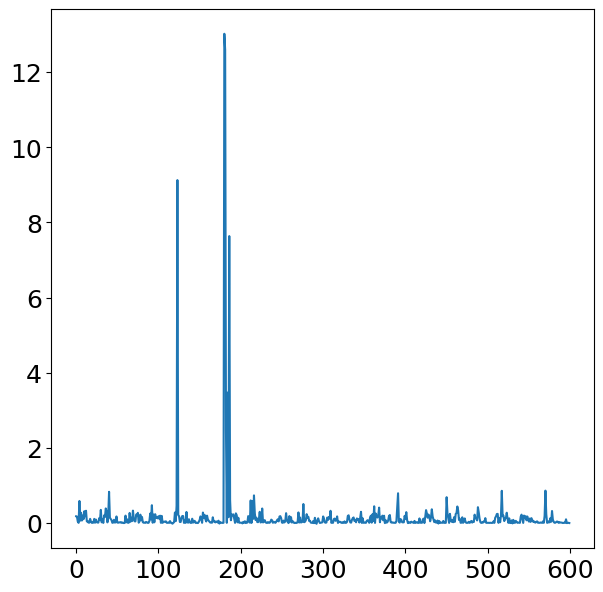

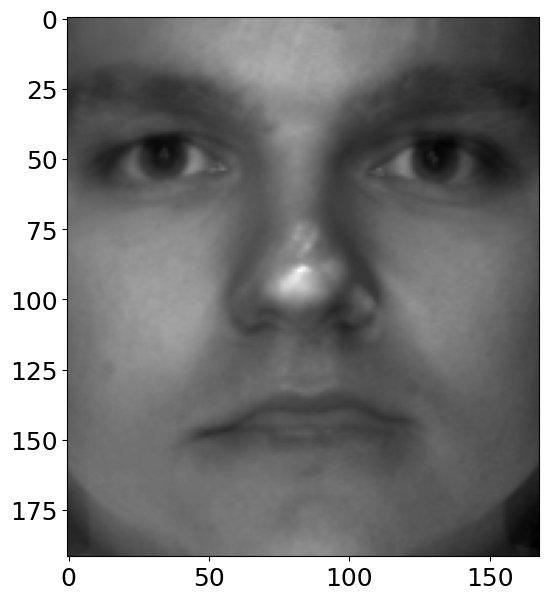

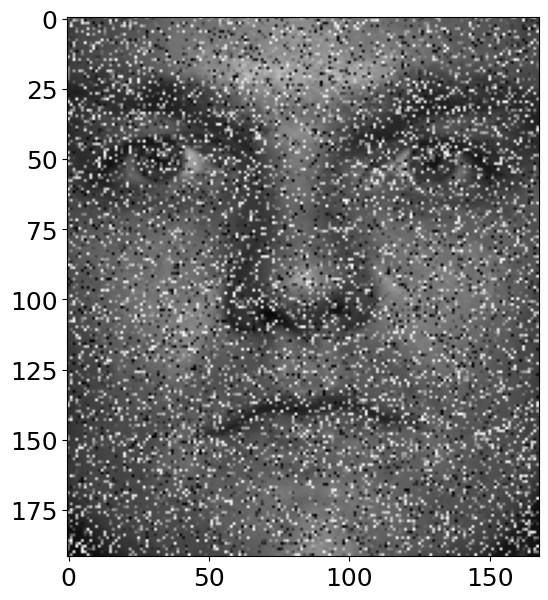

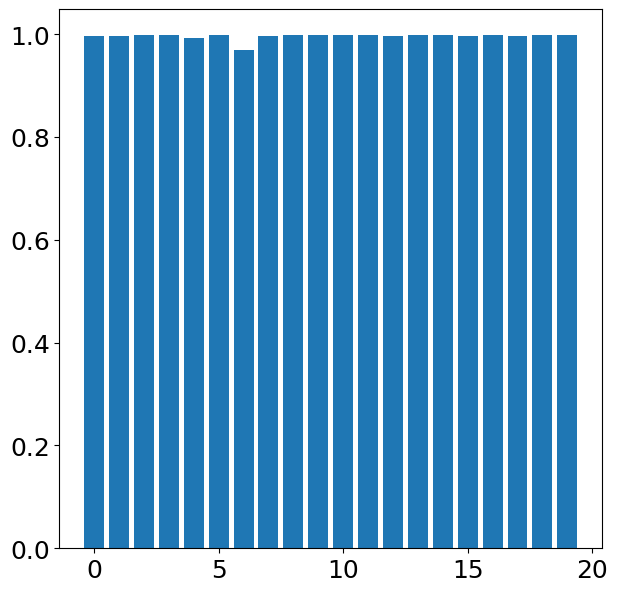

In [92]:
## L1 Search, Occlusion
y3 = np.copy(Y[:,2])
eps = 1000

# L1 Minimum norm solution s_L1
def L1_norm(x):
    return np.linalg.norm(x,ord=1)

constr = ({'type': 'ineq', 'fun': lambda x:  eps - np.linalg.norm(Theta @ x - y3,2)})
x0 = np.linalg.pinv(Theta) @ y3 # initialize with L2 solution
res = minimize(L1_norm, x0, method='SLSQP',constraints=constr)
s3 = res.x

plt.figure()
plt.plot(s3)
plt.figure()
plt.imshow(np.reshape(Train @ (s3/normTheta),(m,n)).T,cmap='gray')
plt.figure()
plt.imshow(np.reshape(x3 - Train @ (s3/normTheta),(m,n)).T,cmap='gray')

binErr = np.zeros(nPeople)
for k in range(nPeople):
    L = range(k*nTrain,(k+1)*nTrain)
    binErr[k] = np.linalg.norm(x3-Train[:,L] @ (s3[L]/normTheta[L]))/np.linalg.norm(x3)
    
plt.figure()
plt.bar(range(nPeople),binErr)
plt.show()

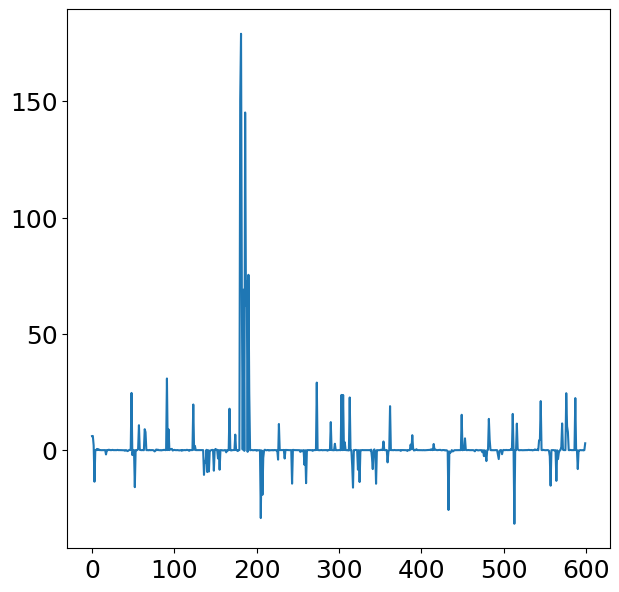

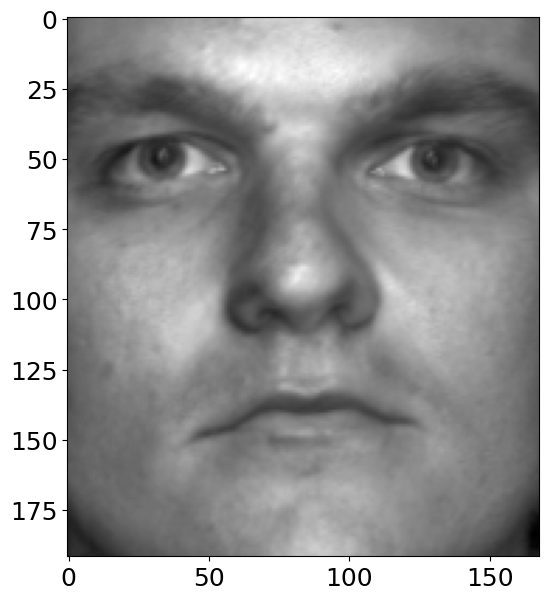

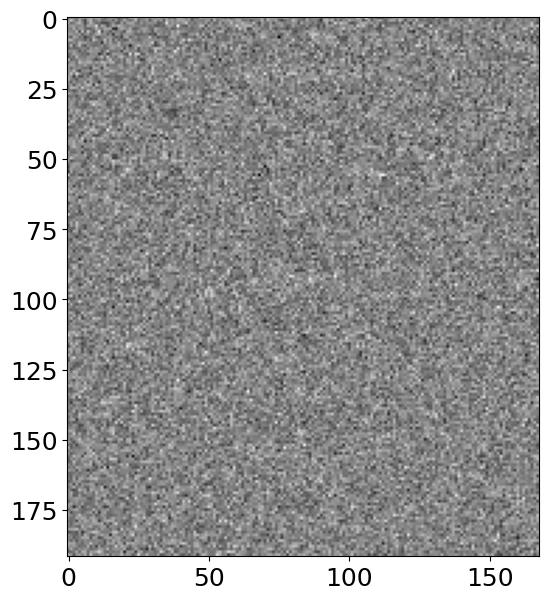

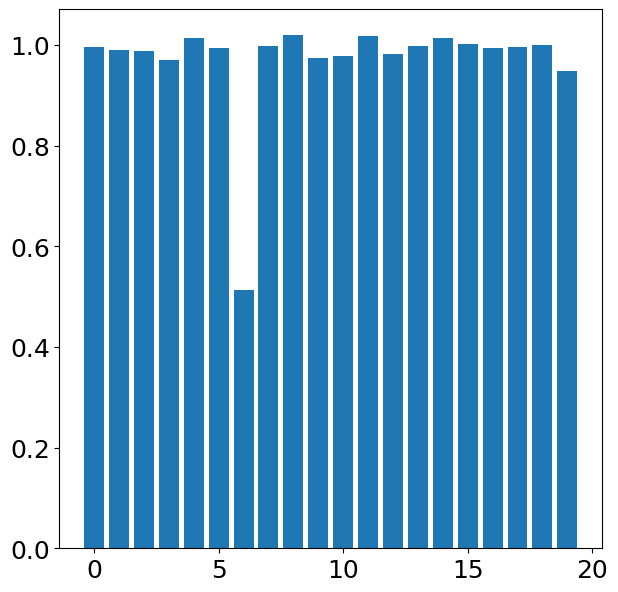

In [93]:
## L1 Search, Noise
y4 = np.copy(Y[:,3])
eps = 10

# L1 Minimum norm solution s_L1
def L1_norm(x):
    return np.linalg.norm(x,ord=1)

constr = ({'type': 'ineq', 'fun': lambda x:  eps - np.linalg.norm(Theta @ x - y4,2)})
x0 = np.linalg.pinv(Theta) @ y4 # initialize with L2 solution
res = minimize(L1_norm, x0, method='SLSQP',constraints=constr)
s4 = res.x


plt.figure()
plt.plot(s4)
plt.figure()
plt.imshow(np.reshape(Train @ (s4/normTheta),(m,n)).T,cmap='gray')
plt.figure()
plt.imshow(np.reshape(x4 - Train @ (s4/normTheta),(m,n)).T,cmap='gray')

binErr = np.zeros(nPeople)
for k in range(nPeople):
    L = range(k*nTrain,(k+1)*nTrain)
    binErr[k] = np.linalg.norm(x4-Train[:,L] @ (s4[L]/normTheta[L]))/np.linalg.norm(x4)
    
plt.figure()
plt.bar(range(nPeople),binErr)
plt.show()

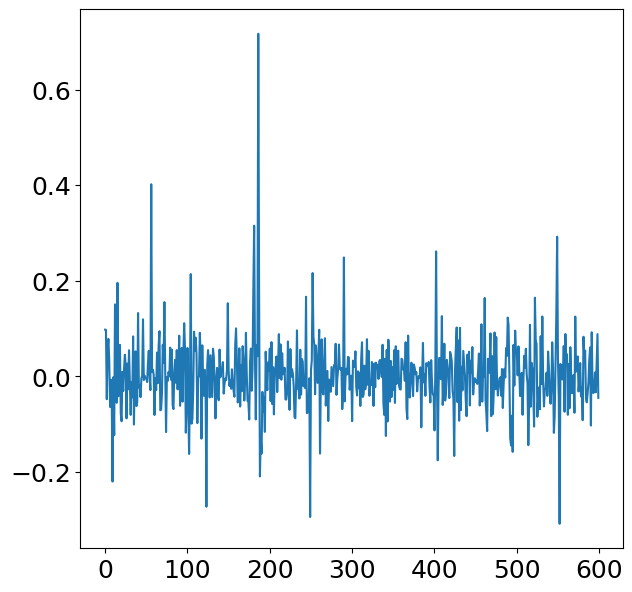

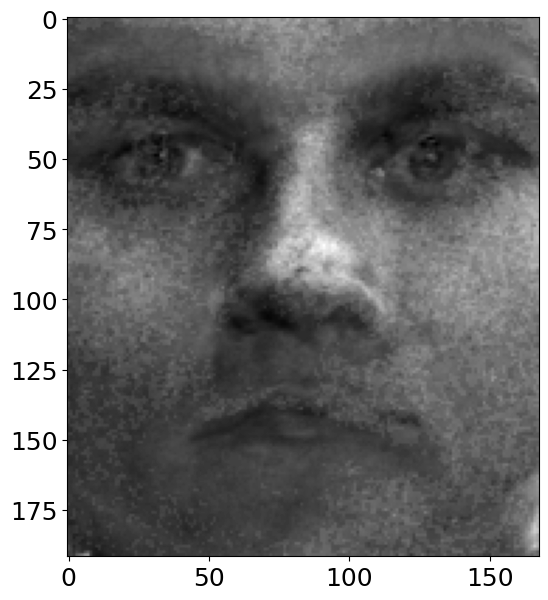

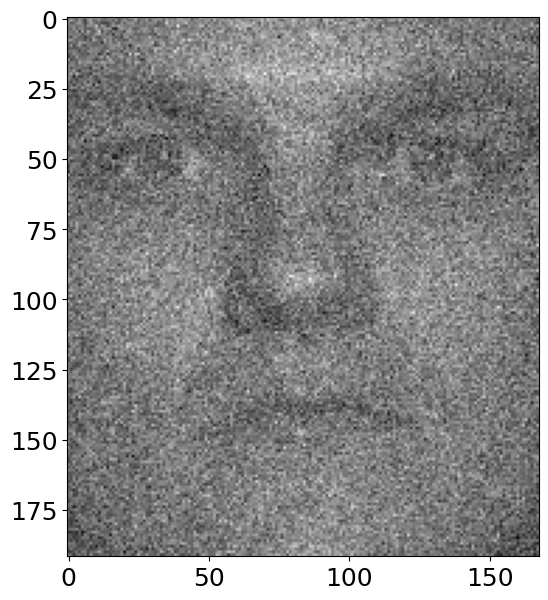

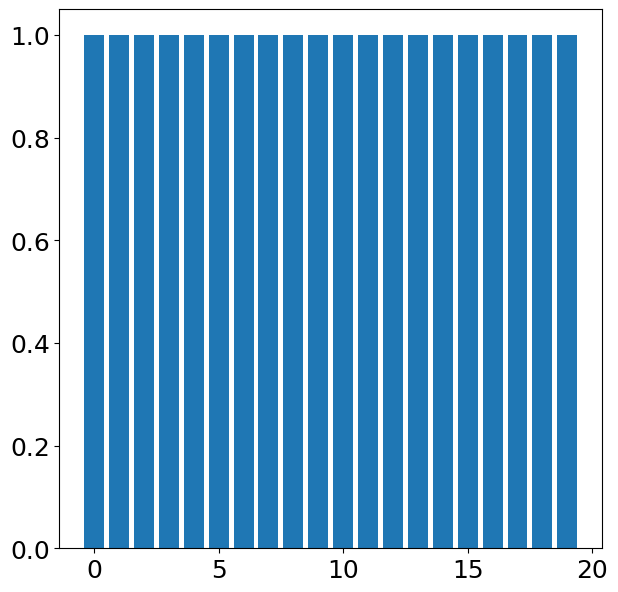

In [94]:
## Least Squares Is No Good
s4L2 = np.linalg.pinv(Train) @ x4
plt.figure()
plt.plot(s4L2)
plt.figure()
plt.imshow(np.reshape(Train @ (s4L2/normTheta),(m,n)).T,cmap='gray')
plt.figure()
plt.imshow(np.reshape(x4 - Train @ (s4L2/normTheta),(m,n)).T,cmap='gray')

binErr = np.zeros(nPeople)
for k in range(nPeople):
    L = range(k*nTrain,(k+1)*nTrain)
    binErr[k] = np.linalg.norm(x4-Train[:,L] @ (s4L2[L]/normTheta[L]))/np.linalg.norm(x4)
    
plt.figure()
plt.bar(range(nPeople),binErr)
plt.show()

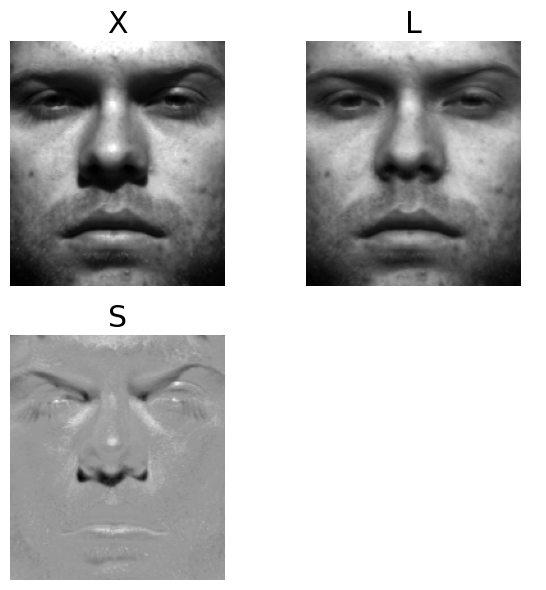

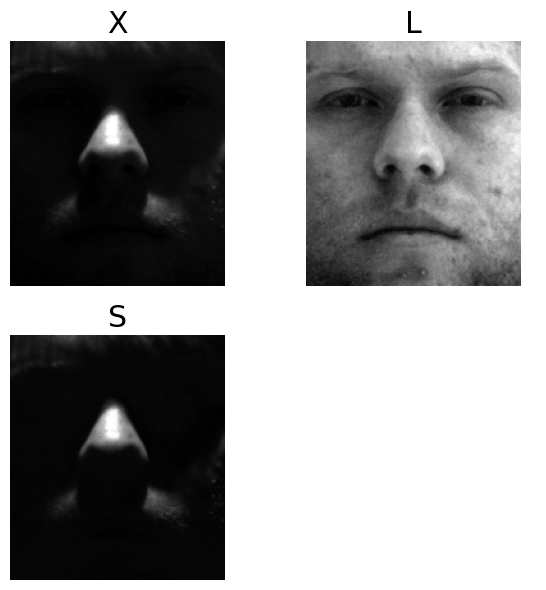

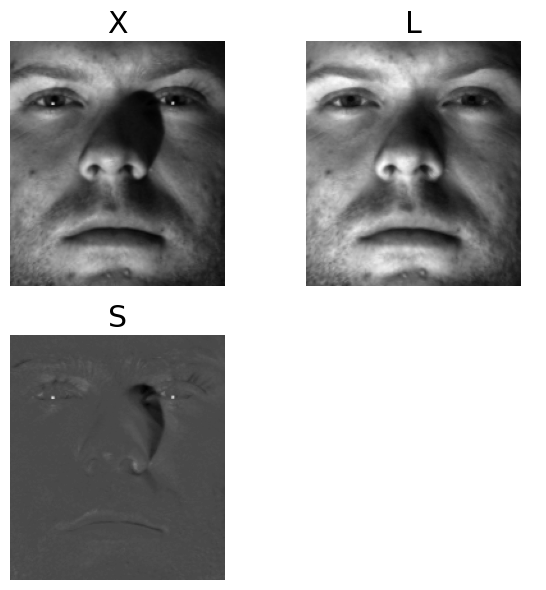

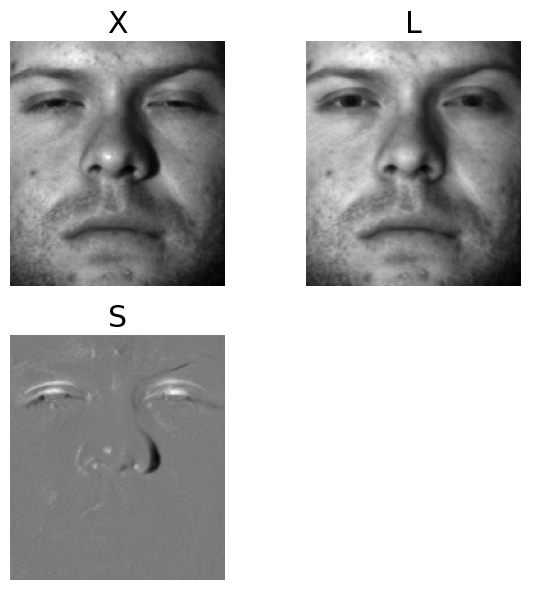

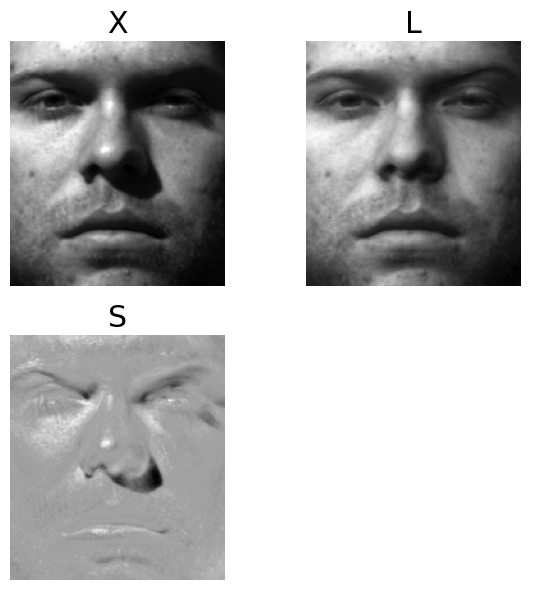

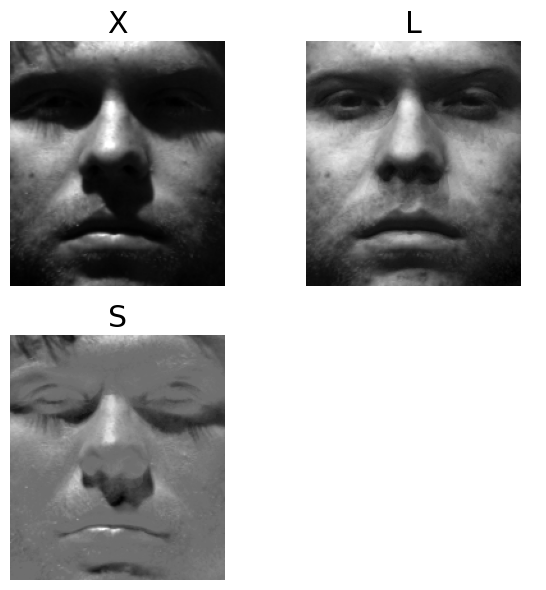

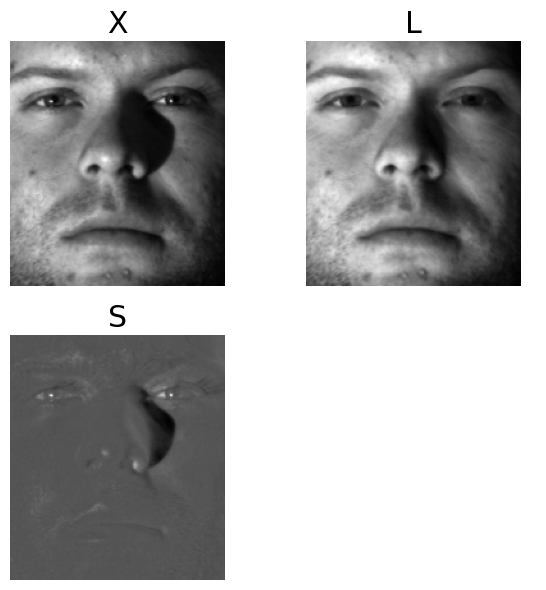

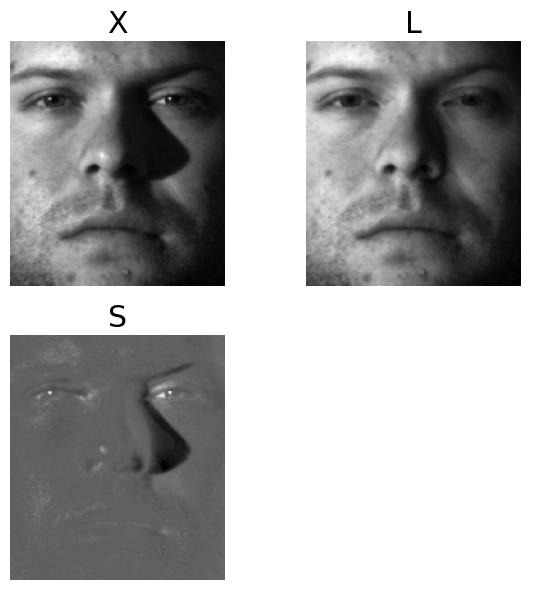

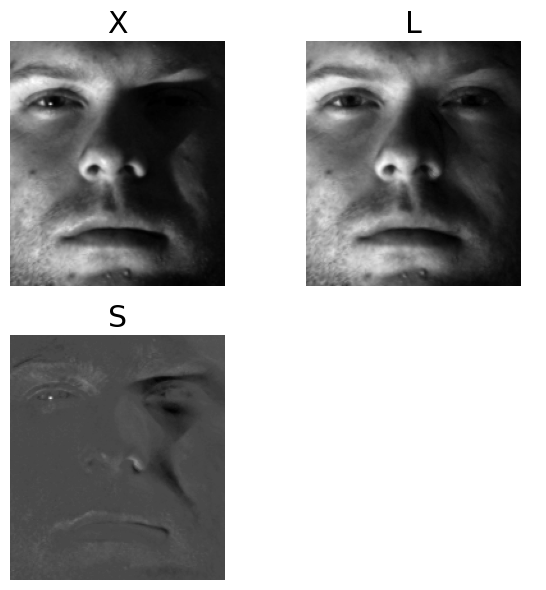

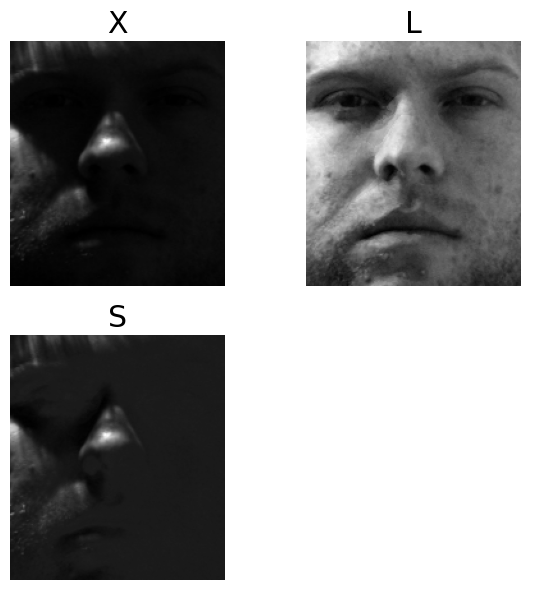

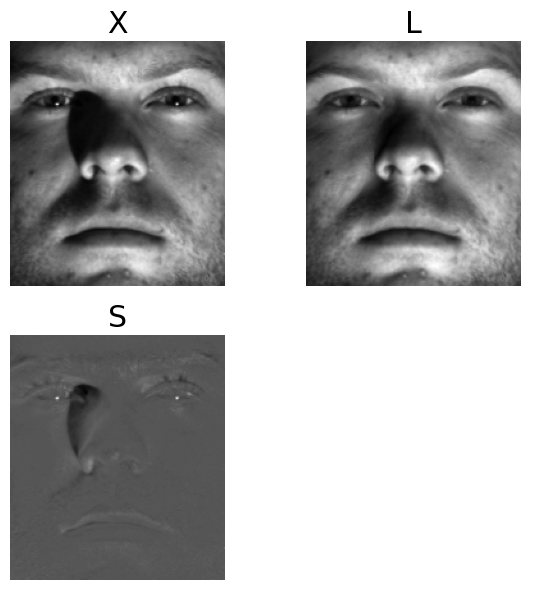

In [14]:
# Robust PCA -- RPCA
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

plt.rcParams['figure.figsize'] = [7, 7]
plt.rcParams.update({'font.size': 18})


mat = scipy.io.loadmat("DATA/allFaces.mat")
faces = mat['faces']
nfaces = mat['nfaces'].reshape(-1)

def shrink(X,tau):
    Y = np.abs(X)-tau
    return np.sign(X)*np.maximum(Y,np.zeros_like(Y))

def SVT(X,tau):
    U, S, VT = np.linalg.svd(X,full_matrices=0)
    out = U@ np.diag(shrink(S,tau)) @ VT
    return out

def RPCA(X):
    n1, n2 = X.shape
    mu = n1*n2/(4*np.sum(np.abs(X.reshape(-1))))
    lambd = 1/np.sqrt(np.maximum(n1,n2))
    thresh = 10**(-7) * np.linalg.norm(X)
    
    S = np.zeros_like(X)
    Y = np.zeros_like(X)
    L = np.zeros_like(X)
    count = 0
    while (np.linalg.norm(X-L-S) > thresh) and (count < 1000):
        L = SVT(X-S+(1/mu)*Y,1/mu)
        S = shrink(X-L+(1/mu)*Y, lambd/mu)
        Y = Y + mu*(X-L-S)
        count +=1
    return L, S
    

X = faces[:,:nfaces[0]]
L,S = RPCA(X)

inds = (3, 4, 14, 15, 17, 18, 19, 20, 21, 32, 43)
for k in inds:
    fig,axs = plt.subplots(2,2)
    axs = axs.reshape(-1)
    axs[0].imshow(np.reshape(X[:,k-1],(168,192)).T,cmap='gray')
    axs[0].set_title('X')
    axs[1].imshow(np.reshape(L[:,k-1],(168,192)).T,cmap='gray')
    axs[1].set_title('L')
    axs[2].imshow(np.reshape(S[:,k-1],(168,192)).T,cmap='gray')
    axs[2].set_title('S')
    for ax in axs:
        ax.axis('off')

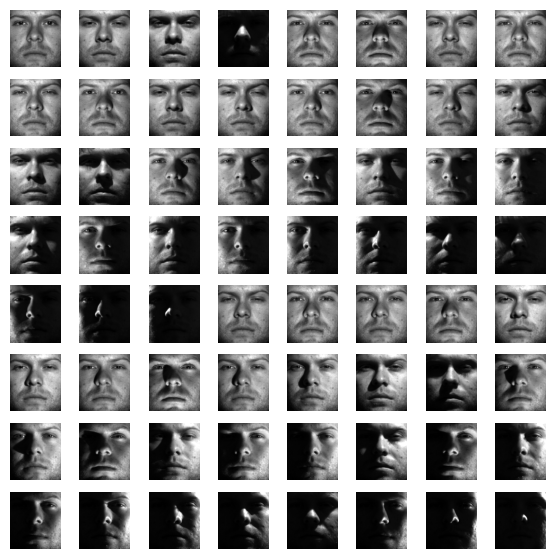

In [15]:
fig,axs = plt.subplots(8,8)

axs = axs.reshape(-1)
for i in range(np.product(axs.shape)):
    axs[i].imshow(np.reshape(X[:,i],(168,192)).T,cmap='gray')
    for ax in axs:
        ax.axis('off')

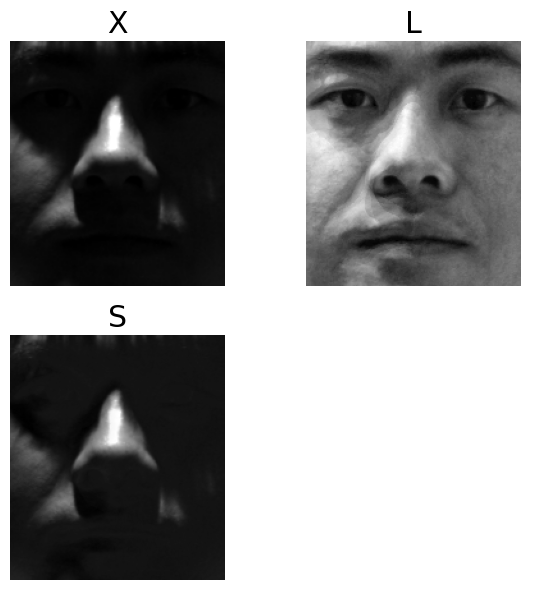

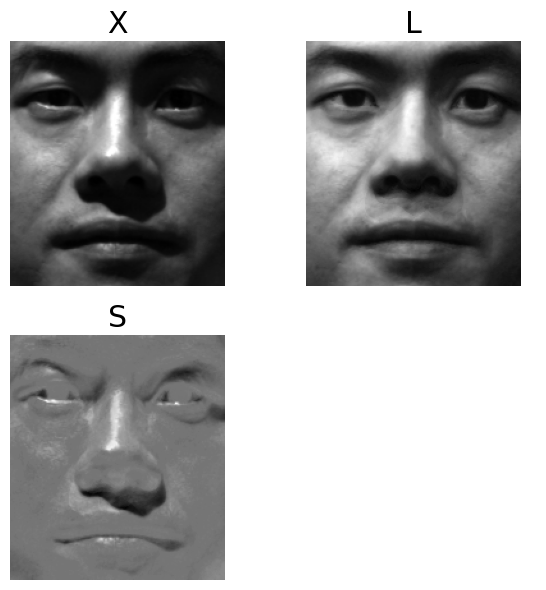

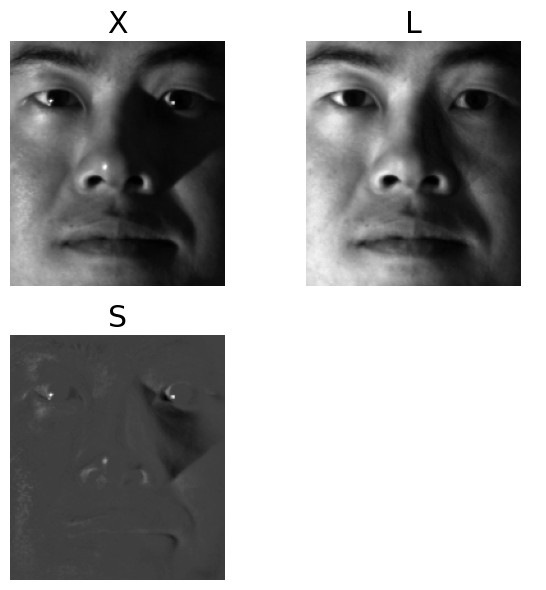

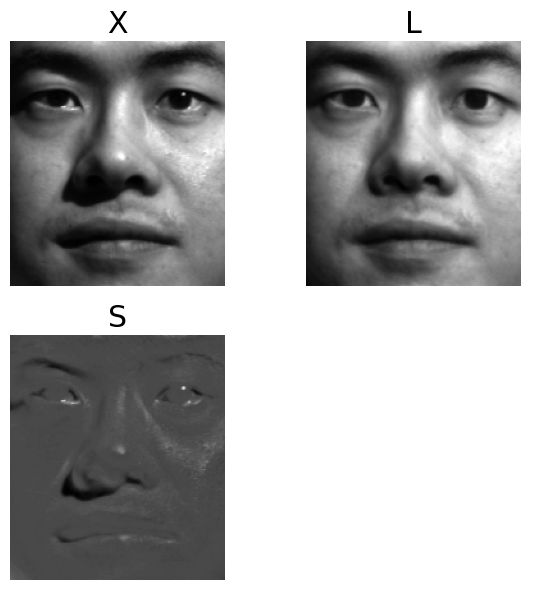

In [16]:
X = faces[:,nfaces[0]+1:nfaces[0] + nfaces[1]]
L,S = RPCA(X)

inds = (3, 15, 20, 43)
for k in inds:
    fig,axs = plt.subplots(2,2)
    axs = axs.reshape(-1)
    axs[0].imshow(np.reshape(X[:,k-1],(168,192)).T,cmap='gray')
    axs[0].set_title('X')
    axs[1].imshow(np.reshape(L[:,k-1],(168,192)).T,cmap='gray')
    axs[1].set_title('L')
    axs[2].imshow(np.reshape(S[:,k-1],(168,192)).T,cmap='gray')
    axs[2].set_title('S')
    for ax in axs:
        ax.axis('off')